In [71]:
import numpy as np
import yfinance as yf
import pandas as pd
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from numpy.typing import NDArray

def portfolio_properties(
        weigths: NDArray[np.float64], 
        log_returns: pd.core.frame.DataFrame,
        risk_free_rate: float = 0.0
    ):

    # Annualized portfolio returns
    mean = np.sum(log_returns.mean() * weigths) * 252

    # Annualized portfolio standard deviation
    sigma = np.sqrt(weigths.T @ log_returns.cov() @ weigths * 252)

    sharpe = (mean - risk_free_rate) / sigma
    
    return mean, sigma, sharpe


## Monte carlo portfolio simulation

In [72]:
stocks = ['EQNR.OL', 'NHY.OL', 'STB.OL', 'TGS.OL', 'TEL.OL', 'YAR.OL']

stock_names = {ticker:yf.Ticker(ticker).info['shortName'] for ticker in stocks}

# Download data
data = yf.download(stocks, period='5Y', interval='1d', progress=False)['Adj Close']

log_returns = np.log(data/data.shift()).dropna()

r = 0.08

size = 10000

weights = np.random.dirichlet(np.ones(len(stocks)), size=size)

results_array = np.zeros((size, 3))

for i, w in enumerate(tqdm(weights)):
    results_array[i] = portfolio_properties(w, log_returns, r)

results = pd.DataFrame(data=results_array, columns=['ret', 'vol', 'sharpe'])

100%|██████████| 10000/10000 [00:06<00:00, 1459.22it/s]


,Optimal Weights
EQUINOR,0.6676
NORSK HYDRO,0.1339
STOREBRAND,0.0651
TGS ASA,0.0015
TELENOR,0.0101
YARA INTERNATIONAL,0.1218


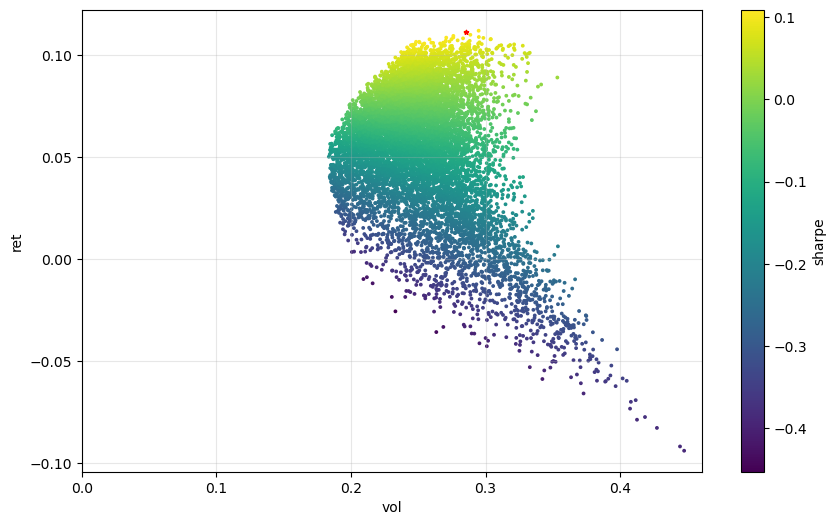

In [73]:
fig, ax = plt.subplots(figsize=(10, 6))

results.plot(
    kind='scatter', 
    x='vol', 
    y='ret', 
    s=3, 
    c='sharpe', 
    cmap='viridis', 
    ax=ax,
    )

ax.set_xlim(left=0)
ax.grid(alpha=0.3)

index = results['sharpe'].idxmax()

ax.scatter(x=results['vol'].loc[index], y=results['ret'].loc[index], color='red', s=10, marker='*')

opt_weights = pd.DataFrame(
    weights[index].round(4), 
    index=stocks, 
    columns=['Optimal Weights']
).rename(stock_names, axis=0)

display(opt_weights)